# Pipeline

This pipeline includes all steps in a single notebook (For Google Colab setup and testing purposes). It is currently a work-in-progress, for now, please visit ./notebooks for the individual steps.

In [49]:
# If you are running this pipeline on Google Colab,
# please update ENVIRONMENT to "GOOGLE_COLAB".
# Otherwise, please update ENVIRONMENT to "LOCAL".

ENVIRONMENT = "LOCAL"

In [50]:
# Recommended to set to True if the data has changed,
# otherwise set to "False" to save time
BYPASS_CACHE = False

# Recommended to set to True if you want to refresh raw dataset
# from the source (Zip file), otherwise set to False to save time
FORCE_UNZIP = False

# Set the random seed for reproducibility
RANDOM_SEED = 42

# Set the test and evaluation sizes
TEST_SIZE = 0.2
EVAL_SIZE = 0.1

# Calculate the train size
TRAIN_SIZE = 1 - TEST_SIZE - EVAL_SIZE

In [51]:
# Set global directories
DEFAULT_DIR = "/content" if ENVIRONMENT == "GOOGLE_COLAB" else "."

DATA_DIR = f"{DEFAULT_DIR}/data"
DATASET_DIR = f"{DATA_DIR}/datasets"

# Caching
CACHE_DIR = f"{DATA_DIR}/cache"
DATASET_CACHE_DIR = f"{CACHE_DIR}/datasets"

# Datasets
TRAIN_DATA_DIR = f"{DATASET_DIR}/raw"
CLEANED_TRAIN_DATA_DIR = f"{DATASET_DIR}/cleaned"
PROCESSED_TRAIN_DATA_DIR = f"{DATASET_DIR}/processed"

# Set path to cache visualizations and models
VISUALIZATION_DIR = f"{CACHE_DIR}/visualizations"
MODEL_DIR = f"{CACHE_DIR}/models"
MACOS_DIR = f"{DATASET_DIR}/__MACOSX"

In [52]:
# Path to raw dataset
GOOGLE_DRIVE_DIR = f"{DEFAULT_DIR}/drive"
GOOGLE_DRIVE_ROOT_DIR = f"{GOOGLE_DRIVE_DIR}/MyDrive"

ZIP_FILE = "Furniture_Data.zip"

DATASET_ZIP = (
    f"{GOOGLE_DRIVE_ROOT_DIR}/{ZIP_FILE}"
    if ENVIRONMENT == "GOOGLE_COLAB"
    else f"{DEFAULT_DIR}/{ZIP_FILE}"
)

DATASET_EXTRACT_DIR = (
    f"{DEFAULT_DIR}/Furniture_Data" if ENVIRONMENT == "GOOGLE_COLAB" else DATASET_DIR
)

In [53]:
if ENVIRONMENT == 'LOCAL':
    %pip install -r requirements.txt
elif ENVIRONMENT == "GOOGLE_COLAB":
    %pip install imagehash

Note: you may need to restart the kernel to use updated packages.


In [54]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

TF version: 2.16.1
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [55]:
if ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount(GOOGLE_DRIVE_DIR, force_remount=True)

In [56]:
from tqdm import tqdm
import zipfile
import shutil
import os

# if force unzip or TRAIN_DATA_DIR doesn't exist or empty
if FORCE_UNZIP or not tf.io.gfile.exists(TRAIN_DATA_DIR):
    if not os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
        print("Starting unzip process...")
        # Extract the zip file
        with zipfile.ZipFile(DATASET_ZIP, "r") as zip_ref:
            zip_ref.extractall(DATASET_EXTRACT_DIR)
        print("Unzip process completed.")

    # Check if the new dataset already directory exists
    print("Checking for existing train dataset directory...")
    if os.path.isdir(TRAIN_DATA_DIR):
        # Delete the new dataset directory
        shutil.rmtree(TRAIN_DATA_DIR)
        print("Existing train dataset directory found and deleted.")

    print("Checking for `__MACOSX` directory...")
    # Check if the `__MACOSX` directory exists
    if os.path.isdir(MACOS_DIR):
        # Delete the `__MACOSX` directory
        shutil.rmtree(MACOS_DIR)
        print("`__MACOSX` directory found and deleted.")
    else:
        print("`__MACOSX` directory not found. Skipping deletion.")

    # Move the extracted dataset to the correct directory
    if os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
        print("Moving extracted dataset to the correct directory...")
        shutil.move(f"{DATASET_EXTRACT_DIR}/Furniture_Data", TRAIN_DATA_DIR)
        print("Dataset moved successfully.")
else:
    print("Skipping unzip process as TRAIN_DATA_DIR exists and FORCE_UNZIP is not set.")

Skipping unzip process as TRAIN_DATA_DIR exists and FORCE_UNZIP is not set.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.auto import tqdm

In [58]:
data = tf.keras.utils.image_dataset_from_directory(TRAIN_DATA_DIR)

Found 90082 files belonging to 6 classes.


In [59]:
import os
import pandas as pd
import imagehash
from PIL import Image
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import tensorflow as tf
import shutil


def image_category(directory):
    cat_list = pd.DataFrame(os.listdir(directory), columns=["Category"])
    for i in cat_list["Category"].values:
        if i == ".DS_Store" or i == "README.txt":
            cat_list.drop(cat_list[cat_list["Category"] == i].index, inplace=True)
    cat_list.reset_index(drop=True, inplace=True)
    return cat_list["Category"].values


def image_style(directory):
    style_list = [
        i
        for i in os.listdir(f"{directory}/beds")
        if os.path.isdir(os.path.join(directory, "beds", i))
        and i not in [".DS_Store", "README.txt"]
    ]
    return style_list


def image_path(directory, category):
    style = image_style(directory)
    image_files = []
    with tqdm(
        total=len(style), desc=f"Getting image path for category '{category}'"
    ) as pbar:
        for st in style:
            path = f"{directory}/{category}/{st}"
            for file in os.listdir(path):
                image_files.append(f"{path}/{file}")
            pbar.update(1)
    return image_files


def compute_hash(path):
    with Image.open(path) as img:
        hash_value = imagehash.average_hash(img)
    return hash_value


def imgResize(lists, size):
    with tqdm(total=len(lists), desc="Resizing images") as pbar:
        for item in lists:
            with Image.open(item) as img:
                img1 = img.resize(size, resample=0)
                img1.save(item, "JPEG")
            pbar.update(1)


def image_duplicate(category, image_files, style):
    hashes = {}
    unique_images = []
    style_images = [img for img in image_files if style in img]

    for image_file in tqdm(
        style_images,
        total=len(style_images),
        desc=f"Finding duplicate images in category '{category}', style '{style}'",
    ):
        try:
            image_hash = compute_hash(image_file)
        except PermissionError:
            print(f"Permission denied for file: {image_file}")
            continue

        if image_hash not in hashes:
            hashes[image_hash] = image_file
            unique_images.append(image_file)
    print(
        f"Category '{category}', Style '{style}': Found {len(style_images) - len(unique_images)} duplicate images."
    )
    return unique_images


def process_images(lists, category):
    category_dir = os.path.join(TRAIN_DATA_DIR, category)

    # Get the list of styles for the current category
    styles = [
        name
        for name in os.listdir(category_dir)
        if os.path.isdir(os.path.join(category_dir, name))
    ]

    # Delete images that does not belong to any style
    for img in lists:
        if not any(style in img for style in styles):
            os.remove(img)
            print(f"Deleted {img} due to unknown style.")

    # Get image sizes
    imageSize = []
    size_counter = Counter()
    with tqdm(total=len(lists), desc="Getting image size") as pbar:
        for item in lists:
            try:
                with Image.open(item) as img:
                    size = img.size
                    imageSize.append(size)
                    size_counter[size] += 1
            except PermissionError:
                print(f"Permission denied for file: {item}")
                continue
            pbar.update(1)
    print("224x224 pixels: ", size_counter[(224, 224)])
    print("350x350 pixels: ", size_counter[(350, 350)])
    print(
        "Other size: ", len(lists) - size_counter[(224, 224)] - size_counter[(350, 350)]
    )

    # Iterate over the styles
    for style in styles:
        cleaned_dir = os.path.join(CLEANED_TRAIN_DATA_DIR, category, style)

        # Check if cleaned images have already been saved
        if os.path.exists(cleaned_dir) and os.listdir(cleaned_dir):
            print(
                f"Category '{category}', Style '{style}': Cleaned images are already available."
            )
            continue

        # Get unique images for the current style
        unique_images = image_duplicate(category, lists, style)

        # Save unique images to CLEANED_TRAIN_DATA_DIR
        os.makedirs(cleaned_dir, exist_ok=True)
        with tqdm(
            total=len(unique_images),
            desc=f"Saving unique images for category '{category}', style '{style}'",
        ) as pbar:
            for img_path in unique_images:
                try:
                    shutil.copy(img_path, cleaned_dir)
                except PermissionError:
                    print(f"Permission denied for file: {img_path}")
                    continue
                pbar.update(1)

        print(
            f"Category '{category}', Style '{style}': Cleaned images saved successfully."
        )

    print(f"Category '{category}': All styles processed successfully.")
    return imageSize

In [60]:
# Define the categories
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

# Extract paths for each category
paths = {category: image_path(TRAIN_DATA_DIR, category) for category in categories}

print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


In [61]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(paths[category])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7871
Amount of lamps: 32402
Amount of sofas: 4080
Amount of tables: 17100
Total: 90084


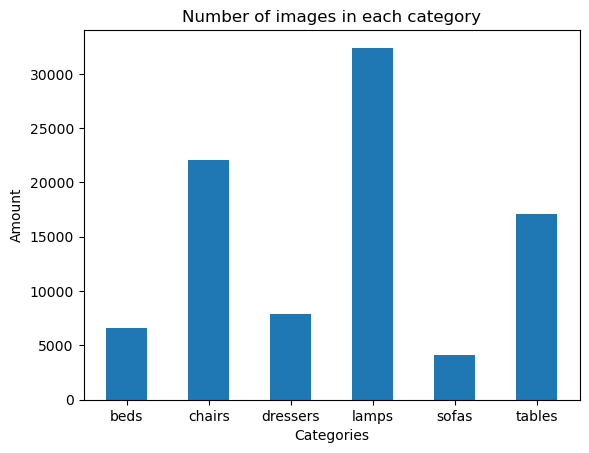

In [62]:
plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

## Get duplicate images from each categories
### Check duplicants and remove duplicants from each categories

In [63]:
# Create a new dictionary to store the paths and image sizes for each category
data = {}
for category, items in paths.items():
    imageSizes = process_images(items, category)
    data[category] = {
        "paths": image_path(CLEANED_TRAIN_DATA_DIR, category),
        "imageSizes": imageSizes,
    }

print("Successfully extracted all paths and image sizes!")

Getting image size:   0%|          | 0/6578 [00:00<?, ?it/s]

224x224 pixels:  6537
350x350 pixels:  41
Other size:  0
Category 'beds', Style 'Asian': Cleaned images are already available.
Category 'beds', Style 'Beach': Cleaned images are already available.
Category 'beds', Style 'Contemporary': Cleaned images are already available.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Category 'beds', Style 'Farmhouse': Cleaned images are already available.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Category 'beds', Style 'Midcentury': Cleaned images are already available.
Category 'beds', Style 'Modern': Cleaned images are already available.
Category 'beds', Style 'Rustic': Cleaned images are already available.
Category 'beds', Style 'Scandinavian': Cleaned images are already available.
Category 'beds', Style 'Southwestern': Cleaned images are 

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image size:   0%|          | 0/22053 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  22053
Other size:  0
Category 'chairs', Style 'Asian': Cleaned images are already available.
Category 'chairs', Style 'Beach': Cleaned images are already available.
Category 'chairs', Style 'Contemporary': Cleaned images are already available.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Category 'chairs', Style 'Farmhouse': Cleaned images are already available.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Category 'chairs', Style 'Midcentury': Cleaned images are already available.
Category 'chairs', Style 'Modern': Cleaned images are already available.
Category 'chairs', Style 'Rustic': Cleaned images are already available.
Category 'chairs', Style 'Scandinavian': Cleaned images are already available.
Category 'chairs', Style 'Southwes

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image size:   0%|          | 0/7871 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  7871
Other size:  0
Category 'dressers', Style 'Asian': Cleaned images are already available.
Category 'dressers', Style 'Beach': Cleaned images are already available.
Category 'dressers', Style 'Contemporary': Cleaned images are already available.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Category 'dressers', Style 'Farmhouse': Cleaned images are already available.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Category 'dressers', Style 'Midcentury': Cleaned images are already available.
Category 'dressers', Style 'Modern': Cleaned images are already available.
Category 'dressers', Style 'Rustic': Cleaned images are already available.
Category 'dressers', Style 'Scandinavian': Cleaned images are already available.
Category 'd

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image size:   0%|          | 0/32402 [00:00<?, ?it/s]

Permission denied for file: ./data/datasets/raw/lamps/Modern/11286modern-lighting.jpg
224x224 pixels:  0
350x350 pixels:  32401
Other size:  1
Category 'lamps', Style 'Asian': Cleaned images are already available.
Category 'lamps', Style 'Beach': Cleaned images are already available.
Category 'lamps', Style 'Contemporary': Cleaned images are already available.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Category 'lamps', Style 'Farmhouse': Cleaned images are already available.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Category 'lamps', Style 'Midcentury': Cleaned images are already available.
Category 'lamps', Style 'Modern': Cleaned images are already available.
Category 'lamps', Style 'Rustic': Cleaned images are already available.
Category 'lamps', Style 'Scandinavian'

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image size:   0%|          | 0/4080 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  4080
Other size:  0
Category 'sofas', Style 'Asian': Cleaned images are already available.
Category 'sofas', Style 'Beach': Cleaned images are already available.
Category 'sofas', Style 'Contemporary': Cleaned images are already available.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Category 'sofas', Style 'Farmhouse': Cleaned images are already available.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Category 'sofas', Style 'Midcentury': Cleaned images are already available.
Category 'sofas', Style 'Modern': Cleaned images are already available.
Category 'sofas', Style 'Rustic': Cleaned images are already available.
Category 'sofas', Style 'Scandinavian': Cleaned images are already available.
Category 'sofas', Style 'Southwestern': Cleaned

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image size:   0%|          | 0/17100 [00:00<?, ?it/s]

224x224 pixels:  0
350x350 pixels:  17099
Other size:  1
Category 'tables', Style 'Asian': Cleaned images are already available.
Category 'tables', Style 'Beach': Cleaned images are already available.
Category 'tables', Style 'Contemporary': Cleaned images are already available.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Category 'tables', Style 'Farmhouse': Cleaned images are already available.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Category 'tables', Style 'Midcentury': Cleaned images are already available.
Category 'tables', Style 'Modern': Cleaned images are already available.
Category 'tables', Style 'Rustic': Cleaned images are already available.
Category 'tables', Style 'Scandinavian': Cleaned images are already available.
Category 'tables', Style 'Southwes

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


### Recheck the categories after removing duplicants

In [64]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(data[category]["paths"])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6542
Amount of chairs: 20067
Amount of dressers: 6650
Amount of lamps: 22980
Amount of sofas: 3385
Amount of tables: 16070
Total: 75694


### Visualization

Text(0, 0.5, 'Amount')

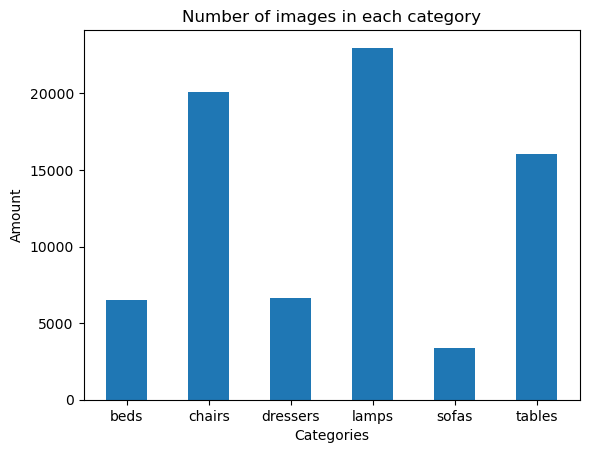

In [65]:
plt.bar(
    categories, [len(data[category]["paths"]) for category in categories], width=0.5
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")

-   In the plot we can see the differences between of the amount in different columns. Because of that, we will need to check for the imbalances of our dataset

## Get different amount of image size of each category

In [66]:
# Define a dictionary to store the dataframes
# each category in df_dims is data[category][imageSizes]
df_dims = {
    category: pd.DataFrame(data[category]["imageSizes"], columns=["width", "height"])
    for category in categories
}

print("Successfully extracted all dimensions!")

Successfully extracted all dimensions!


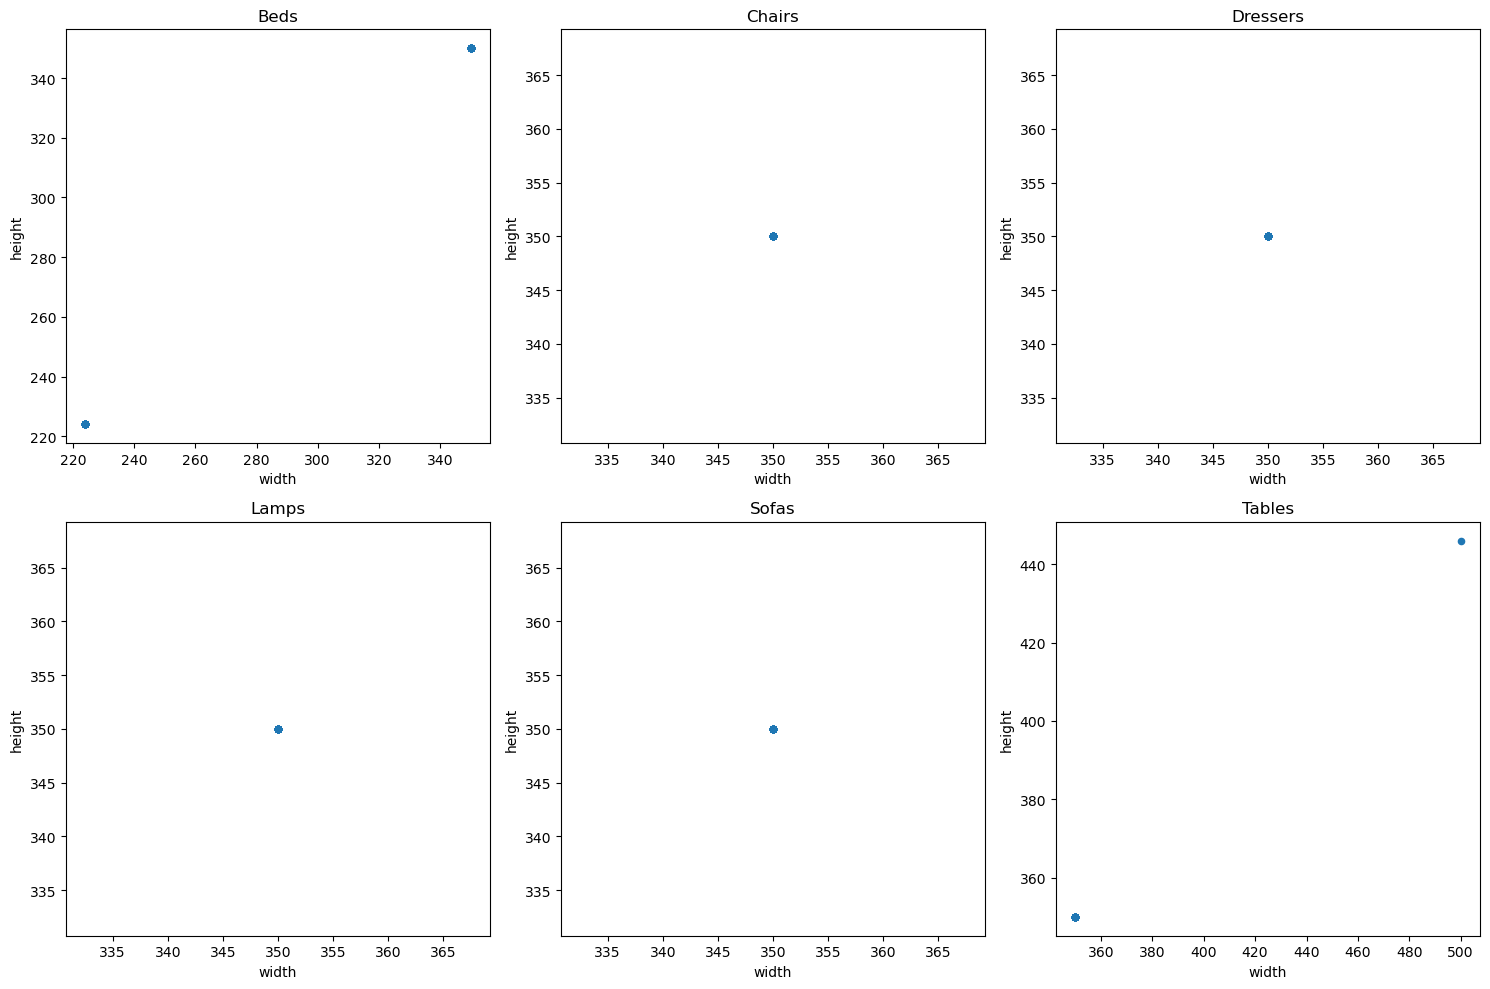

In [67]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
n_rows = 2
n_cols = 3

# Create the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array
axs = axs.flatten()

# Iterate over the categories and axes
for ax, category in zip(axs, categories):
    # Create the scatter plot for the current category
    df_dims[category].plot.scatter(
        x="width", y="height", ax=ax, title=category.capitalize()
    )

# Adjust the layout
plt.tight_layout()
plt.show()

In [68]:
# Iterate over the categories
for category in categories:
    print(category.capitalize())
    display(df_dims[category].describe().T)

Beds


,count,mean,std,min,25%,50%,75%,max
width,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0
height,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0


Chairs


,count,mean,std,min,25%,50%,75%,max
width,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Dressers


,count,mean,std,min,25%,50%,75%,max
width,7871.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,7871.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Lamps


,count,mean,std,min,25%,50%,75%,max
width,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Sofas


,count,mean,std,min,25%,50%,75%,max
width,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Tables


,count,mean,std,min,25%,50%,75%,max
width,17100.0,350.008772,1.147079,350.0,350.0,350.0,350.0,500.0
height,17100.0,350.005614,0.734130,350.0,350.0,350.0,350.0,446.0


- The dataset contains 6 categories of items with 90083 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446